In [1]:
# !pip install --upgrade git+ssh://git@github.com/flavell-lab/flv_utils.git
# !pip install --upgrade git+ssh://git@github.com/flavell-lab/private_MultiAnimalBleachCorrect.git
# !pip list

In [1]:
%env JAX_DEBUG_NANS=false
%env CUDA_VISIBLE_DEVICES=3
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.9

# public libraries
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import jax.scipy.stats.norm as norm
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import seaborn as sns
from scipy import stats
from scipy.special import softmax
import h5py
import numpy as np
from genjax.typing import FloatArray
from genjax import ChoiceMap
import itertools

key = jax.random.PRNGKey(314159)

env: JAX_DEBUG_NANS=false
env: CUDA_VISIBLE_DEVICES=3
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.9


In [2]:
# flavell lab libraries
import flv_utils as flv

import cepnem_jax as cj
from cepnem_jax import (
    prob_P_greater_Q,
    benjamini_hochberg,
    compute_AND,
    neuron_p_values,
    compute_ζ,
    compute_s,
    CePNEM_120, 
    get_CePNEM_data
)

def compute_α(α0):
    return norm.cdf(α0)
    
def compute_σSE(σ0_SE):
    return σ_SE_MEAN * jnp.exp(σ0_SE * σ_SE_STD)

def compute_σnoise(σ0_noise):
    return σ_NOISE_MEAN * jnp.exp(σ0_noise * σ_NOISE_STD)

def _combine(pair1, pair2):
    r1, a1 = pair1
    r2, a2 = pair2
    return (r1 * r2, a2 + r2 * a1)

def noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh):
    """Returns the noiseless neuron activity for a single animal from one posterior sample"""
    # Compute the rectification and the activation
    E = s / (s + 1)  # EMWA decay factor
    R = (c_vT + 1) / jnp.sqrt(c_vT**2 + 1)  # Rectification factor
    M = -2 * c_vT / jnp.sqrt(c_vT**2 + 1)  # Modulation factor

    # Compute the activation
    std_v, std_th, std_P = std_beh.T
    a_t = (R + M * (std_v < 0)) * (c_v * std_v + c_θh * std_th + c_P * std_P) / (s + 1)

    A = a_t + b * (1.0 - E)

    # Prepare the pairs for the associative scan
    pairs = (jnp.full_like(A, E), A)
    r_pref, a_pref = jax.lax.associative_scan(_combine, pairs, axis=0)

    # Compute the final activation
    return y0 * r_pref + a_pref   


def deconvolved_model(c_vT, c_v, c_θh, c_P, s, std_beh):
    """Returns the noiseless acute neuron activation for a single animal from one posterior sample"""
    # Compute the rectification and the activation
    E = s / (s + 1)  # EMWA decay factor
    R = (c_vT + 1) / jnp.sqrt(c_vT**2 + 1)  # Rectification factor
    M = -2 * c_vT / jnp.sqrt(c_vT**2 + 1)  # Modulation factor

    # Compute the activation
    std_v, std_th, std_P = std_beh.T
    a_t = (R + M * (std_v < 0)) * (c_v * std_v + c_θh * std_th + c_P * std_P) / (s + 1)

    return a_t # Acute activity, normalized by EWMA decay factor

Sourcing files from flv-c servers


/storage/fs/store1/candy/candy_cepnem/private_cepnem_jax/.venv/lib/python3.12/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(


In [3]:
def noiseless_one_animal(params, behs, animal_idx=0):
    """Return (S, T): predictions for one animal across S samples."""
    beh_single = jnp.asarray(behs[animal_idx])            # (T, 3)

    # Per-sample parameter vectors (S,)
    c_vT = jnp.asarray(params['c_vT']).reshape(-1)
    c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
    c_th = jnp.asarray(params['c_θh']).reshape(-1)
    c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
    svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

    # Baseline for this animal across samples -> (S,)
    b_all = jnp.asarray(params['local']['b'])             # (S, N) or (S, 1, N)
    bvec  = jnp.squeeze(jnp.take(b_all, animal_idx, axis=-1)).reshape(-1)

    f = jax.vmap(
        lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i, b_i:
            noiseless_model(c_vT_i, c_v_i, c_th_i, c_P_i, 0., s_i, b_i, beh_single),
        in_axes=(0, 0, 0, 0, 0, 0)
    )
    return jax.jit(f)(c_vT, c_v, c_th, c_P, svec, bvec)   # (S, T)


def noiseless_all_animals(params, behs):
    """Return (N, S, T): predictions for all animals."""
    # Stack behaviors so we can vmap over animals without list indexing
    beh_stack = jnp.stack([jnp.asarray(b) for b in behs], axis=0)  # (N, T, 3)
    N = beh_stack.shape[0]
    animal_idx = jnp.arange(N)                                     # traced indices OK now

    def per_animal(beh_single, ai):
        # Same logic as noiseless_one_animal but avoid list indexing
        c_vT = jnp.asarray(params['c_vT']).reshape(-1)
        c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
        c_th = jnp.asarray(params['c_θh']).reshape(-1)
        c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
        svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

        b_all = jnp.asarray(params['local']['b'])                  # (S, N) or (S, 1, N)
        bvec  = jnp.squeeze(jnp.take(b_all, ai, axis=-1)).reshape(-1)

        f = jax.vmap(
            lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i, b_i:
                noiseless_model(c_vT_i, c_v_i, c_th_i, c_P_i, 0., s_i, b_i, beh_single),
            in_axes=(0, 0, 0, 0, 0, 0)
        )
        return f(c_vT, c_v, c_th, c_P, svec, bvec)                 # (S, T)

    vm = jax.vmap(per_animal, in_axes=(0, 0))
    return jax.jit(vm)(beh_stack, animal_idx)                      # (N, S, T)

In [4]:
def deconvolved_one_animal(params, behs, animal_idx=0):
    """Return (S, T): acute activity for one animal across S posterior samples."""
    beh_single = jnp.asarray(behs[animal_idx])  # (T, 3)

    # Per-sample parameter vectors (S,)
    c_vT = jnp.asarray(params['c_vT']).reshape(-1)
    c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
    c_th = jnp.asarray(params['c_θh']).reshape(-1)
    c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
    svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

    f = jax.vmap(
        lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i:
            deconvolved_model(c_vT_i, c_v_i, c_th_i, c_P_i, s_i, beh_single),
        in_axes=(0, 0, 0, 0, 0)
    )
    return jax.jit(f)(c_vT, c_v, c_th, c_P, svec)  # (S, T)


def deconvolved_all_animals(params, behs):
    """Return (N, S, T): acute activity for all animals."""
    beh_stack = jnp.stack([jnp.asarray(b) for b in behs], axis=0)  # (N, T, 3)
    N = beh_stack.shape[0]
    animal_idx = jnp.arange(N)

    def per_animal(beh_single, ai):
        c_vT = jnp.asarray(params['c_vT']).reshape(-1)
        c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
        c_th = jnp.asarray(params['c_θh']).reshape(-1)
        c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
        svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

        f = jax.vmap(
            lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i:
                deconvolved_model(c_vT_i, c_v_i, c_th_i, c_P_i, s_i, beh_single),
            in_axes=(0, 0, 0, 0, 0)
        )
        return f(c_vT, c_v, c_th, c_P, svec)  # (S, T)

    vm = jax.vmap(per_animal, in_axes=(0, 0))
    return jax.jit(vm)(beh_stack, animal_idx)  # (N, S, T)


@jax.jit
def calc_deconvolved_activity_matrix(params, beh_ranges):
    """Return (S, V, H, P) grid of acute activity.
       beh_ranges = (v_rng, θh_rng, P_rng) as 1D arrays."""
    v_rng, θh_rng, P_rng = beh_ranges

    # Per-sample parameter vectors (S,)
    c_vT = jnp.asarray(params['c_vT']).reshape(-1)
    c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
    c_θh = jnp.asarray(params['c_θh']).reshape(-1)
    c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
    svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

    # Map: samples → v → θh → P
    return jax.vmap(
        lambda c_vT_i, c_v_i, c_θh_i, c_P_i, s_i:
            jax.vmap(
                lambda v_i:
                    jax.vmap(
                        lambda θh_i:
                            jax.vmap(
                                lambda P_i: deconvolved_model(
                                    c_vT_i, c_v_i, c_θh_i, c_P_i, s_i,
                                    jnp.array([[v_i, θh_i, P_i]])  # (1,3)
                                )[0]  # take scalar from length-1 time dim
                            )(P_rng)
                    )(θh_rng)
            )(v_rng)
    )(c_vT, c_v, c_θh, c_P, svec)

In [11]:
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250820'

nc = 'AVA'
# group = 'scramble'
group = 'gfp'

path_output = f'{full_model_dir}/{nc}/{group}.h5'
result = flv.h5_to_dict(path_output)
truth = result['ys']
output = result['CePNEMOutput']
std_beh = result['beh']
posterior = output['posterior_samples']

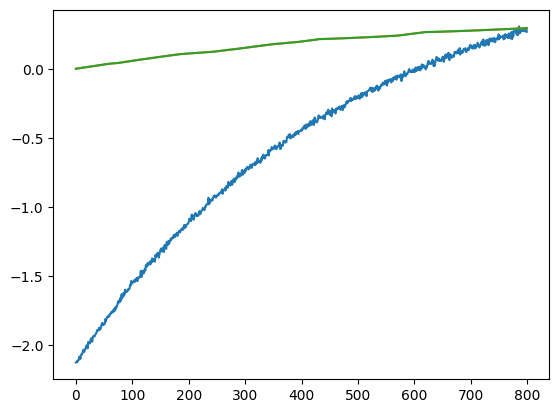

In [12]:
# Noiseless model
animal_idx = 0
pred_one_animal  = noiseless_one_animal(posterior, std_beh, animal_idx=animal_idx)  # (S, T)
pred_all_animals = noiseless_all_animals(posterior, std_beh)                        # (N, S, T)

plt.plot(truth[animal_idx])
plt.plot(jnp.median(pred_one_animal, axis=0))
plt.plot(jnp.median(pred_all_animals[animal_idx], axis=0))

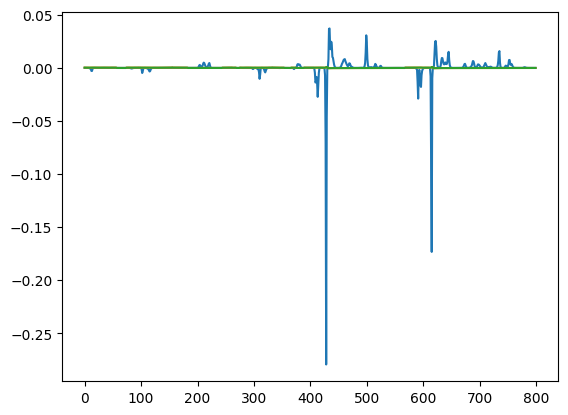

In [13]:
# Deconvolved model
animal_idx = 0
pred_one_animal  = deconvolved_one_animal(posterior, std_beh, animal_idx=animal_idx)  # (S, T)
pred_all_animals = deconvolved_all_animals(posterior, std_beh)                        # (N, S, T)

plt.plot(std_beh[animal_idx, :, 0])
plt.plot(jnp.median(pred_one_animal, axis=0))
plt.plot(jnp.median(pred_all_animals[animal_idx], axis=0))

In [5]:
def compute_forwardness(deconv_matrix):
    M = deconv_matrix.copy()
    n_particles = M.shape[0]
    
    # Extract and flatten the matrices for all particles at once
    # Shape: (n_particles, flattened_size)
    M_n1jk = M[:, 0, :, :].reshape(n_particles, -1)
    M_n2jk = M[:, 1, :, :].reshape(n_particles, -1)
    M_n3jk = M[:, 2, :, :].reshape(n_particles, -1)
    M_n4jk = M[:, 3, :, :].reshape(n_particles, -1)
    
    # Calculate slopes for ALL particles at once
    slope_forward = M_n4jk - M_n3jk  # Shape: (n_particles, flattened_size)
    slope_reverse = M_n2jk - M_n1jk  # Shape: (n_particles, flattened_size)
    forwardness = slope_forward + slope_reverse  # Shape: (n_particles, flattened_size)
    
    # Calculate mean slopes across the flattened dimension (axis=1)
    all_slope_forward = jnp.mean(slope_forward, axis=1)  # Shape: (n_particles,)
    all_slope_reverse = jnp.mean(slope_reverse, axis=1)  # Shape: (n_particles,)
    all_forwardness = jnp.mean(forwardness, axis=1)      # Shape: (n_particles,)
        
    return (all_slope_forward, all_slope_reverse, all_forwardness)

def plot_velocity_tuning(deconv_matrix, v_rng, all_forwardness, title='',
                        n_subset=200, linecolor="black", figsize=(5,5), 
                        alpha=0.1, random_seed=1, ax=None, show_plot=True,
                        label=None):
    """
    Plot tuning curve for velocity in forward and reverse locomotion.
    
    Parameters:
    -----------
    deconv_matrix : array
        Deconvolution matrix with shape (n_samples, 4, j, k)
    v_rng : array-like
        Velocity range values [v1, v2, v3, v4]
    all_forwardness : array
        Array of forwardness values for statistics
    n_subset : int, default=200
        Number of lines to sample and plot
    linecolor : str, default="black"
        Color for the lines
    figsize : tuple, default=(5, 5)
        Figure size (width, height)
    alpha : float, default=0.1
        Alpha value for individual line plots
    random_seed : int, default=1
        Random seed for reproducible sampling
    ax : matplotlib.axes.Axes, optional
        Existing axes to plot on. If None, creates new figure
    show_plot : bool, default=True
        Whether to call plt.show() at the end
    label : str, optional
        Label for the legend
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    ax : matplotlib.axes.Axes
        The plot axes
    """
    
    # Extract matrix values for each velocity point
    M = deconv_matrix
    M_n1jk = M[:, 0, :, :].flatten()
    M_n2jk = M[:, 1, :, :].flatten()
    M_n3jk = M[:, 2, :, :].flatten()
    M_n4jk = M[:, 3, :, :].flatten()
    
    # Calculate mean values for each velocity tickmark
    M_n1jk_mean = float(np.mean(M_n1jk))
    M_n2jk_mean = float(np.mean(M_n2jk))
    M_n3jk_mean = float(np.mean(M_n3jk))
    M_n4jk_mean = float(np.mean(M_n4jk))
    
    # Calculate slopes for EACH pair of points
    slope_forward = M_n4jk - M_n3jk
    slope_reverse = M_n2jk - M_n1jk
    forwardness = slope_forward + slope_reverse
    
    # Create PRNG keys
    key1 = jax.random.PRNGKey(random_seed)
    key2 = jax.random.PRNGKey(random_seed + 1)
    key3 = jax.random.PRNGKey(random_seed + 2)
    key4 = jax.random.PRNGKey(random_seed + 3)
    
    # Sample with replacement
    max_idx = len(M_n1jk)
    idx1 = jax.random.randint(key1, shape=(n_subset,), minval=0, maxval=max_idx)
    idx2 = jax.random.randint(key2, shape=(n_subset,), minval=0, maxval=max_idx)
    idx3 = jax.random.randint(key3, shape=(n_subset,), minval=0, maxval=max_idx)
    idx4 = jax.random.randint(key4, shape=(n_subset,), minval=0, maxval=max_idx)
    
    # Define tickmarks for plotting
    v1_mean, v2_mean, v3_mean, v4_mean = v_rng
    
    # Create the plot or use existing axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Plot reverse slope (v1 to v2) - individual lines
    for i in range(n_subset):
        ax.plot([v1_mean, v2_mean], [M_n1jk[idx1[i]], M_n2jk[idx2[i]]], 
                color=linecolor, alpha=alpha, linewidth=0.3)
    
    # Plot reverse slope mean line
    ax.plot([v1_mean, v2_mean], [M_n1jk_mean, M_n2jk_mean], 
            color=linecolor, linewidth=3)
    
    # Plot forward slope (v3 to v4) - individual lines
    for i in range(n_subset):
        ax.plot([v3_mean, v4_mean], [M_n3jk[idx3[i]], M_n4jk[idx4[i]]], 
                color=linecolor, alpha=alpha, linewidth=0.3)
    
    # Plot forward slope mean line (with label for legend if provided)
    ax.plot([v3_mean, v4_mean], [M_n3jk_mean, M_n4jk_mean], 
            color=linecolor, linewidth=3, label=label)
    
    # Set title and labels (only if this is a new plot)
    if ax.get_title() == '':  # Only set if no title exists
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Standardized Velocity', fontsize=14, fontweight='bold')
        ax.set_ylabel('Deconvolved Activity (a.u.)', fontsize=14, fontweight='bold')
    
    # Set x-axis ticks
    ax.set_xticks([v1_mean, v2_mean, v3_mean, v4_mean])
    ax.set_xticklabels([f"{v:.2f}" for v in v_rng])
    
    # Show plot if requested
    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, ax

In [6]:
def plot_ridge(
        data_dict,
        figsize=(4,4),
        alpha=0.6,
        spacing=0.1,          
        peak_height=0.2,
        title='',
        xlabel='',
        colors=None,
        xlim=None,
        ax=None  # New parameter to accept existing axis
    ):
    """
    Ridge plot with minimal vertical spacing so curves overlap pleasingly.
    ---------------------------------------------------
    spacing      : vertical offset between successive ridges
    peak_height  : how tall (in y-units) every ridge's maximum will be
    ax           : existing matplotlib axis to plot on (optional)
    """
    # Create new figure only if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=100)
    else:
        fig = ax.get_figure()
    
    keys         = list(data_dict.keys())
    n_conditions = len(keys)
    if not colors:
        colors   = plt.cm.viridis(np.linspace(0, 1, n_conditions))
    
    # overall x-range
    all_vals     = np.concatenate(list(data_dict.values()))
    if not xlim:
        x_min, x_max = all_vals.min()*0.5, all_vals.max()*1.5
    else:
        x_min = xlim[0]
        x_max = xlim[1]
    x_range = np.linspace(x_min, x_max, 400)
    
    y_positions = []
    for i, (cond, vals) in enumerate(data_dict.items()):
        y0 = -i * spacing
        y_positions.append(y0)
        if len(vals) > 1:
            kde = stats.gaussian_kde(vals)
            dens = kde(x_range)
            
            # Handle division by zero safely
            if dens.max() > 0:
                dens_scaled = dens / dens.max() * peak_height
            else:
                # If all density values are 0, create a flat line at y0
                dens_scaled = np.zeros_like(dens)
            
            ax.fill_between(x_range, y0, dens_scaled + y0,
                            color=colors[i], alpha=alpha,
                            linewidth=0)
            ax.plot(x_range, dens_scaled + y0, color=colors[i], lw=1.8)
        # tiny rug for data points
        ax.scatter(vals, np.full_like(vals, y0 - spacing*0.12),
                   color='black', alpha=0.01, s=14, marker='|')
    
    # cosmetics
    ax.axvline([0], color='black', alpha=0.5) 
    ax.set_xlim(x_min, x_max)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(keys, fontsize=12)
    ax.set_xlabel(xlabel,  fontsize=14, fontweight='bold')
    ax.set_ylabel('Conditions', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # declutter
    ax.spines[['top', 'right', 'left']].set_visible(False)
    
    # Only call tight_layout if we created the figure
    if ax is None:
        plt.tight_layout()
    
    return fig, ax

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'AVA: Velocity Tuning'}, xlabel='Standardized Velocity', ylabel='Deconvolved Activity (a.u.)'>)

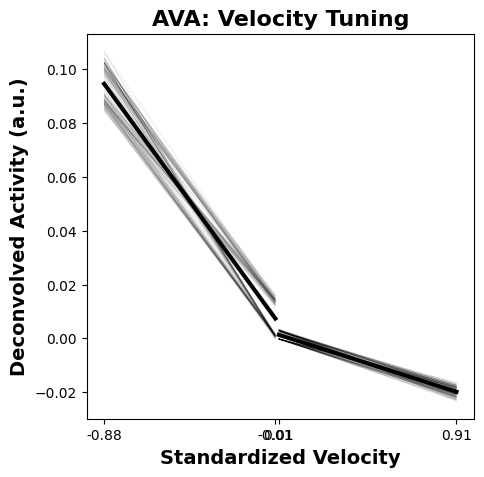

In [20]:
nc = 'AVA'

group = 'sparse_food'

full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250820'
path_output = f'{full_model_dir}/{nc}/{group}.h5'
result = flv.h5_to_dict(path_output)
truth = result['ys']
output = result['CePNEMOutput']
posterior = output['posterior_samples']

# # Set behavior tick marks for making deconvolved matrix
# v_flat = std_beh[:, :, 0].flatten()
# theta_H_flat = std_beh[:, :, 1].flatten()
# P_flat = std_beh[:, :, 2].flatten()

# med_rev_speed = jnp.median(v_flat[jnp.where(v_flat < 0)])
# med_fwd_speed = jnp.median(v_flat[jnp.where(v_flat > 0)])
# v_rng = jnp.array(
#     [med_rev_speed, med_rev_speed / 100, med_fwd_speed / 100, med_fwd_speed]
# )
# theta_H_rng = jnp.array(
#     [jnp.percentile(theta_H_flat, 25), jnp.percentile(theta_H_flat, 75)]
# )
# P_rng = jnp.array([jnp.percentile(P_flat, 25), jnp.percentile(P_flat, 75)])

deconv_matrix = calc_deconvolved_activity_matrix(
    posterior, (v_rng, theta_H_rng, P_rng)
)
(all_slope_forward, all_slope_reverse, all_forwardness) = compute_forwardness(deconv_matrix)

plot_velocity_tuning(deconv_matrix, v_rng, all_forwardness, title=f'{nc}: Velocity Tuning',
                        linecolor='black', show_plot=False)

In [ ]:
# Get standardized behavior values for generation of traces only
_, all_beh, neuron_data = get_CePNEM_data(
    "OLQD", # found reasonable number of times across all conditions
    exclude=[],
    include=['neuropal'], 
    confidence_threshold=1)
all_beh = jnp.array(all_beh)

# Set behavior tick marks for making deconvolved matrix
v_flat = all_beh[:, :, 0].flatten()
theta_H_flat = all_beh[:, :, 1].flatten()
P_flat = all_beh[:, :, 2].flatten()

med_rev_speed = jnp.median(v_flat[jnp.where(v_flat < 0)])
med_fwd_speed = jnp.median(v_flat[jnp.where(v_flat > 0)])
v_rng = jnp.array(
    [med_rev_speed, med_rev_speed / 100, med_fwd_speed / 100, med_fwd_speed]
)
theta_H_rng = jnp.array(
    [jnp.percentile(theta_H_flat, 25), jnp.percentile(theta_H_flat, 75)]
)
P_rng = jnp.array([jnp.percentile(P_flat, 25), jnp.percentile(P_flat, 75)])

In [12]:
# Get matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Your conditions
all_conditions = ['dense_food', 'sparse_food', 'just_fed', 'fasted', '1h_starved', 'copper', 'gfp', 'scramble'] 

# Create the color dictionary
dict_color = {condition: default_colors[i % len(default_colors)] for i, condition in enumerate(all_conditions)}

In [10]:
result.keys()

dict_keys(['CePNEMOutput', 'beh', 'beh_unnorm', 'group_signal', 'ys', 'ys_unnorm'])

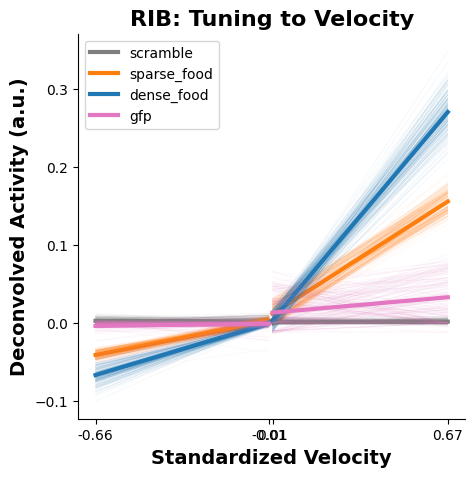

In [25]:
nc = 'RIB'
all_conditions = ['scramble', 'sparse_food', 'dense_food', 'gfp']

# Create figure with two subplots of equal width
fig, ax1 = plt.subplots(1, 1, figsize=(5,5)) #, gridspec_kw={'width_ratios': [1, 1]})

# First plot: Velocity tuning curves
dict_forwardness = {}
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250820'

for condition in all_conditions:
    path_output = f'{full_model_dir}/{nc}/{condition}.h5'
    result = flv.h5_to_dict(path_output)
    # traces = result['ys']
    # std_beh = result['beh']
    output = result['CePNEMOutput']
    posterior = output['posterior_samples']
    
    # Set behavior tick marks for making deconvolved matrix
    # v_flat = std_beh[:, :, 0].flatten()
    # theta_H_flat = std_beh[:, :, 1].flatten()
    # P_flat = std_beh[:, :, 2].flatten()
    
    # med_rev_speed = jnp.median(v_flat[jnp.where(v_flat < 0)])
    # med_fwd_speed = jnp.median(v_flat[jnp.where(v_flat > 0)])
    # v_rng = jnp.array(
    #     [med_rev_speed, med_rev_speed / 100, med_fwd_speed / 100, med_fwd_speed]
    # )
    # theta_H_rng = jnp.array(
    #     [jnp.percentile(theta_H_flat, 25), jnp.percentile(theta_H_flat, 75)]
    # )
    # P_rng = jnp.array([jnp.percentile(P_flat, 25), jnp.percentile(P_flat, 75)])
    
    deconv_matrix = calc_deconvolved_activity_matrix(
        posterior, (v_rng, theta_H_rng, P_rng)
    )
    (slope_forward, slope_reverse, forwardness) = compute_forwardness(deconv_matrix)
    signal = result['group_signal']
    dict_forwardness[condition] = forwardness #* signal
    
    plot_velocity_tuning(deconv_matrix, v_rng, dict_forwardness[condition], title=f'{nc}: Tuning to Velocity',
                         linecolor=dict_color[condition], 
                         ax=ax1, show_plot=False, label=condition)

# Format first subplot - remove top and right spines only
ax1.legend()
# ax1.set_ylim(-4,4)
# ax1.set_ylim(-2,2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

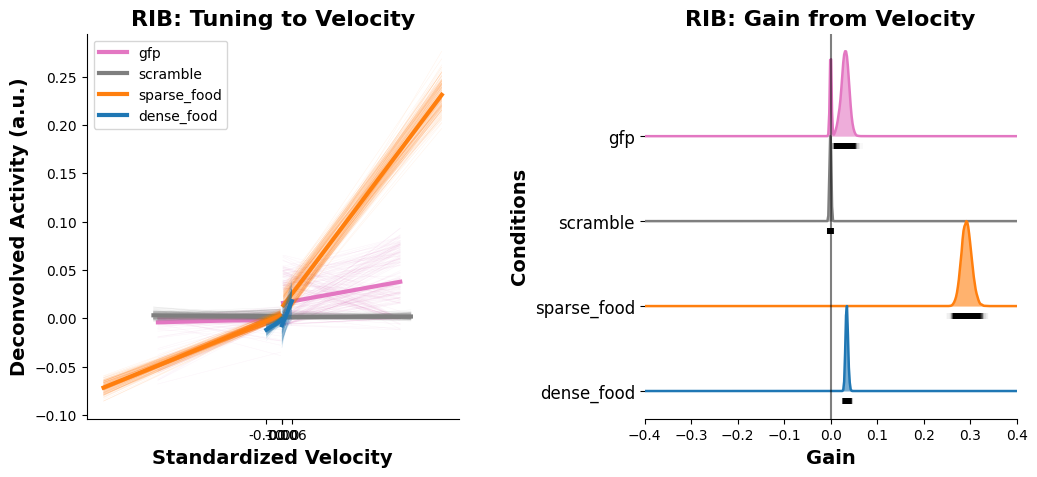

In [19]:
nc = 'RIB'
all_conditions = ['sparse_food', 'dense_food', 'gfp', 'scramble']

# Create figure with two subplots of equal width
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) #, gridspec_kw={'width_ratios': [1, 1]})

# First plot: Velocity tuning curves
dict_forwardness = {}
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250820'

for condition in all_conditions:
    path_output = f'{full_model_dir}/{nc}/{condition}.h5'
    result = flv.h5_to_dict(path_output)
    # traces = result['ys']
    std_beh = result['beh']
    output = result['CePNEMOutput']
    posterior = output['posterior_samples']
    
    # Set behavior tick marks for making deconvolved matrix
    v_flat = std_beh[:, :, 0].flatten()
    theta_H_flat = std_beh[:, :, 1].flatten()
    P_flat = std_beh[:, :, 2].flatten()
    
    med_rev_speed = jnp.median(v_flat[jnp.where(v_flat < 0)])
    med_fwd_speed = jnp.median(v_flat[jnp.where(v_flat > 0)])
    v_rng = jnp.array(
        [med_rev_speed, med_rev_speed / 100, med_fwd_speed / 100, med_fwd_speed]
    )
    theta_H_rng = jnp.array(
        [jnp.percentile(theta_H_flat, 25), jnp.percentile(theta_H_flat, 75)]
    )
    P_rng = jnp.array([jnp.percentile(P_flat, 25), jnp.percentile(P_flat, 75)])
    
    deconv_matrix = calc_deconvolved_activity_matrix(
        posterior, (v_rng, theta_H_rng, P_rng)
    )
    (slope_forward, slope_reverse, forwardness) = compute_forwardness(deconv_matrix)
    signal = result['group_signal']
    dict_forwardness[condition] = forwardness #* signal
    
    plot_velocity_tuning(deconv_matrix, v_rng, dict_forwardness[condition], title=f'{nc}: Tuning to Velocity',
                         linecolor=dict_color[condition], 
                         ax=ax1, show_plot=False, label=condition)

# Format first subplot - remove top and right spines only
ax1.legend()
# ax1.set_ylim(-4,4)
# ax1.set_ylim(-2,2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Second plot: Ridge plot
color_scheme = []
for condition in all_conditions:
    color_scheme.append(dict_color[condition])

plot_ridge(dict_forwardness, 
           colors=color_scheme, 
           spacing=0.2, 
           xlim=(-0.4,0.4), 
           xlabel="Gain",
           title=f'{nc}: Gain from Velocity',
           ax=ax2) 

plt.subplots_adjust(wspace=0.5)
# plt.savefig(f'/home/candy/candy_testing/power_analysis/tuning_curves_{neuron_class}_velocity/{i}animals.png', 
#             dpi=300)
plt.show()

In [57]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from sklearn.metrics import mutual_info_score

# ---------- KSG MI (Algorithm 1) ----------
def mi_kraskov(x, y, k=5, standardize=True, eps=1e-10):
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    assert x.shape == y.shape and x.ndim == 1, "x and y must be 1-D with equal length"
    N = x.size
    if N <= k:
        raise ValueError("Need N > k samples for KSG estimator.")

    if standardize:
        x = (x - x.mean()) / (x.std() + 1e-12)
        y = (y - y.mean()) / (y.std() + 1e-12)

    Z = np.column_stack([x, y])

    # k-NN in joint space using Chebyshev (∞-norm)
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='chebyshev').fit(Z)
    dists, _ = nbrs.kneighbors(Z)
    # distance to the k-th neighbor (exclude self at idx 0)
    radii = dists[:, k] - eps

    # Count neighbors in marginals within that joint radius
    nx = np.empty(N, dtype=int)
    ny = np.empty(N, dtype=int)
    for i in range(N):
        nx[i] = (np.abs(x - x[i]) <= radii[i]).sum() - 1
        ny[i] = (np.abs(y - y[i]) <= radii[i]).sum() - 1

    # Kraskov (Alg. 1)
    mi_nats = digamma(k) + digamma(N) - np.mean(digamma(nx + 1) + digamma(ny + 1))
    return float(mi_nats)

# ---------- Intuitive [0,1] scales ----------
def mi_to_r2_equivalent(mi_nats):
    """
    Monotone mapping: S = 1 - exp(-2 * I)
    - Equals r^2 for jointly Gaussian variables
    - Always in [0,1), increasing with I
    """
    return 1.0 - np.exp(-2.0 * mi_nats)

def symmetric_uncertainty_discrete(x, y, n_bins=28, rank_uniformize=True):
    """
    Classic normalized MI: SU = 2 * I / (H(X) + H(Y)) in [0,1]
    Uses discretization (robust and intuitive). Optionally rank-uniformize first.
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if rank_uniformize:
        # Map to copula uniforms U(0,1) via ranks (ties averaged)
        xr = (np.argsort(np.argsort(x)) + 0.5) / len(x)
        yr = (np.argsort(np.argsort(y)) + 0.5) / len(y)
        x = xr; y = yr

    # Equal-width bins on [min,max] of each (after rank, that’s ~[0,1])
    x_b = np.digitize(x, bins=np.histogram_bin_edges(x, bins=n_bins))
    y_b = np.digitize(y, bins=np.histogram_bin_edges(y, bins=n_bins))

    # Entropies via mutual_info_score trick
    Hx = mutual_info_score(x_b, x_b)
    Hy = mutual_info_score(y_b, y_b)
    Ixy = mutual_info_score(x_b, y_b)
    if Hx <= 0 or Hy <= 0:
        return 0.0
    return float(2.0 * Ixy / (Hx + Hy))

MI (nats): 1.521
R²‑equivalent from MI: 0.952
Symmetric Uncertainty (discrete NMI): 0.484


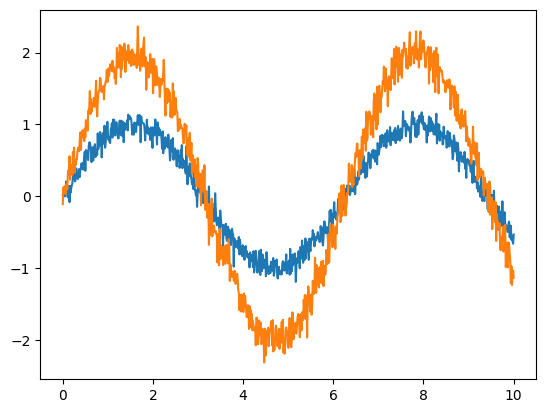

In [59]:
rng = np.random.default_rng(0)
t = np.linspace(0, 10, 800)
x = np.sin(t) + 0.1 * rng.normal(size=t.size)
y = 2.0 * np.sin(t) + 0.15 * rng.normal(size=t.size)
# y = 2.0 * np.sin(t + 0.4) + 0.15 * rng.normal(size=t.size)

# MI in nats via KSG
mi_nats = mi_kraskov(x, y, k=5)
print(f"MI (nats): {mi_nats:.3f}")

# Intuitive, bounded scale ~ “fraction explained”
s_pred = mi_to_r2_equivalent(mi_nats)
print(f'R²‑equivalent from MI: {s_pred:.3f}')

# Optional: Discrete normalized MI (symmetric uncertainty) as a cross-check
su = symmetric_uncertainty_discrete(x, y, n_bins=28, rank_uniformize=True)
print(f"Symmetric Uncertainty (discrete NMI): {su:.3f}")

plt.plot(t, x)
plt.plot(t, y)

In [60]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from scipy.stats import pearsonr, spearmanr

# ---------- KSG MI (Algorithm 1) ----------
def mi_kraskov(x, y, k=5, standardize=True, eps=1e-10):
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    assert x.shape == y.shape and x.ndim == 1
    N = x.size
    if N <= k:
        raise ValueError("Need N > k samples for KSG estimator.")

    if standardize:
        x = (x - x.mean()) / (x.std() + 1e-12)
        y = (y - y.mean()) / (y.std() + 1e-12)

    Z = np.column_stack([x, y])
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='chebyshev').fit(Z)
    dists, _ = nbrs.kneighbors(Z)
    radii = dists[:, k] - eps  # joint k-NN radius (minus tiny eps for strict counts)

    nx = np.empty(N, dtype=int)
    ny = np.empty(N, dtype=int)
    for i in range(N):
        nx[i] = (np.abs(x - x[i]) <= radii[i]).sum() - 1
        ny[i] = (np.abs(y - y[i]) <= radii[i]).sum() - 1

    mi_nats = digamma(k) + digamma(N) - np.mean(digamma(nx + 1) + digamma(ny + 1))
    return float(mi_nats)

def mi_to_r2_equivalent(mi_nats):
    return 1.0 - np.exp(-2.0 * mi_nats)

def three_metrics(x, y):
    # Pearson R^2
    r, _ = pearsonr(x, y)
    r2 = r**2

    # Spearman rho^2
    rho, _ = spearmanr(x, y)
    rho2 = rho**2

    # MI -> R^2-equivalent
    mi_nats = mi_kraskov(x, y, k=5)
    s_pred = mi_to_r2_equivalent(mi_nats)

    return r2, rho2, s_pred

# ------------------ Toy experiments ------------------
rng = np.random.default_rng(0)
N = 800
t = np.linspace(0, 4*np.pi, N)

# 1) Linear relation
x1 = rng.normal(size=N)
y1 = 1.5*x1 + 0.5*rng.normal(size=N)

# 2) Monotonic nonlinear (quadratic, with noise)
x2 = rng.uniform(-2, 2, size=N)
y2 = (x2**2) + 0.2*rng.normal(size=N)  # monotonic on [0,∞) after squaring, but non-linear

# 3) Non-monotonic (sinusoid over multiple cycles)
x3 = t
y3 = np.sin(t) + 0.15*rng.normal(size=N)

# 4) Independent noise
x4 = rng.normal(size=N)
y4 = rng.normal(size=N)

labels = ["Linear", "Monotonic nonlinear (quadratic)", "Non-monotonic (sinusoid)", "Independent"]
pairs = [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]

print(f"{'Case':35s}  {'Pearson R^2':>12s}  {'Spearman ρ^2':>12s}  {'MI→R²eq':>10s}")
for name, (x, y) in zip(labels, pairs):
    r2, rho2, s_pred = three_metrics(x, y)
    print(f"{name:35s}  {r2:12.3f}  {rho2:12.3f}  {s_pred:10.3f}")


Case                                  Pearson R^2  Spearman ρ^2     MI→R²eq
Linear                                      0.908         0.898       0.911
Monotonic nonlinear (quadratic)             0.002         0.010       0.958
Non-monotonic (sinusoid)                    0.146         0.138       0.933
Independent                                 0.000         0.000      -0.002


In [67]:
import numpy as np

def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b)**2)))

def fit_affine(src, tgt):
    """Least-squares fit of a,b in a*src + b ≈ tgt; returns a,b."""
    src = np.asarray(src); tgt = np.asarray(tgt)
    x = src - src.mean()
    y = tgt - tgt.mean()
    var_x = np.mean(x*x)
    a = 0.0 if var_x == 0 else (np.mean(x*y) / var_x)
    b = tgt.mean() - a * src.mean()
    return float(a), float(b)

def affine_invariant_rmse(recon, target):
    """RMSE after optimal affine alignment of recon to target."""
    a, b = fit_affine(recon, target)
    return rmse(a * np.asarray(recon) + b, target)

def pearson_r(a, b, eps=1e-12):
    a = np.asarray(a); b = np.asarray(b)
    a0 = a - a.mean(); b0 = b - b.mean()
    denom = (np.linalg.norm(a0) * np.linalg.norm(b0)) + eps
    return float(np.dot(a0, b0) / denom)

def si_sdr_db(est, ref, center=True, eps=1e-12):
    """
    Scale-Invariant SDR (dB). Optionally mean-center to ignore baseline.
    """
    s = np.asarray(ref); sh = np.asarray(est)
    if center:
        s = s - s.mean(); sh = sh - sh.mean()
    alpha = (np.dot(sh, s) / (np.dot(s, s) + eps))
    s_target = alpha * s
    e = sh - s_target
    num = np.dot(s_target, s_target)
    den = np.dot(e, e) + eps
    return 10.0 * np.log10(num / den + eps)

def compare_to_ground_truth(gt, recon_a, recon_b=None):
    """
    Returns a dict of metrics for recon_a (and recon_b if provided) vs ground truth.
    """
    out = {}
    for name, x in (("A", recon_a),) if recon_b is None else (("A", recon_a), ("B", recon_b)):
        out[name] = {
            "RMSE": rmse(x, gt),
            "AffineInv_RMSE": affine_invariant_rmse(x, gt),
            "Pearson_r": pearson_r(x, gt),
            "SI_SDR_dB": si_sdr_db(x, gt, center=True),
        }
    if recon_b is not None:
        # Symmetric closeness between reconstructions (average both alignment directions)
        ai_rmse_AtoB = affine_invariant_rmse(recon_a, recon_b)
        ai_rmse_BtoA = affine_invariant_rmse(recon_b, recon_a)
        out["A_vs_B"] = {
            "AffineInv_RMSE_sym": 0.5 * (ai_rmse_AtoB + ai_rmse_BtoA),
            "Pearson_r": pearson_r(recon_a, recon_b),
            "SI_SDR_dB(centered)": si_sdr_db(recon_a, recon_b, center=True)
        }
    return out

A {'RMSE': 0.8569044849794123, 'AffineInv_RMSE': 0.17756972545359573, 'Pearson_r': 0.9646587557448968, 'SI_SDR_dB': 11.271784574209583}
B {'RMSE': 0.2996650180206445, 'AffineInv_RMSE': 0.19132775236364838, 'Pearson_r': 0.9588484479322029, 'SI_SDR_dB': 10.571128827152801}
A_vs_B {'AffineInv_RMSE_sym': 0.352179819133749, 'Pearson_r': 0.9227482775487819, 'SI_SDR_dB(centered)': 7.583358839105111}


A {'RMSE': 0.8466440490877499, 'AffineInv_RMSE': 0.1353505718957567, 'Pearson_r': 0.9796216454638573, 'SI_SDR_dB': 13.763654377417334}
B {'RMSE': 0.6856060912600913, 'AffineInv_RMSE': 0.11281702988806225, 'Pearson_r': 0.9858867850750891, 'SI_SDR_dB': 15.400736495180885}
A_vs_B {'AffineInv_RMSE_sym': 0.2167364347902706, 'Pearson_r': 0.9867805644422271, 'SI_SDR_dB(centered)': 15.690783591739399}


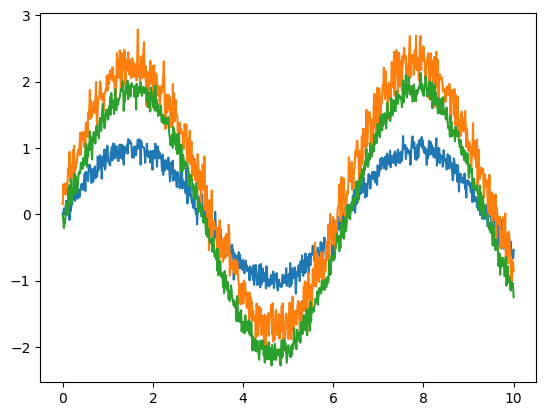

In [71]:
rng = np.random.default_rng(0)
t = np.linspace(0, 10, 800)
gt = np.sin(t) + 0.1 * rng.normal(size=t.size)

# Two reconstructions with baseline and scale differences
recon1 = 2.0 * np.sin(t) + 0.3 + 0.20 * rng.normal(size=t.size)
recon2 = 2.0 * np.sin(t) - 0.1 + 0.10 * rng.normal(size=t.size)

metrics = compare_to_ground_truth(gt, recon1, recon2)
for k, v in metrics.items():
    print(k, v)


plt.plot(t, gt)
plt.plot(t, recon1)
plt.plot(t, recon2)

In [87]:
# import jax.flatten_util as jflat

# def chm_cosine_similarity(chm1: ChoiceMap, chm2: ChoiceMap) -> FloatArray:
#     """Calculates the negative cosine similarity between two ChoiceMaps

#     Args:
#         chm1 (ChoiceMap): The first ChoiceMap
#         chm2 (ChoiceMap): The second ChoiceMap

#     Returns:
#         FloatArray: The cosine similarity between the two ChoiceMaps
#     """
#     dot_product = jnp.sum(
#         jflat.ravel_pytree(chm1)[0] * jflat.ravel_pytree(chm2)[0], axis=-1
#     )
#     norm1 = jnp.linalg.norm(jflat.ravel_pytree(chm1)[0], axis=-1)
#     norm2 = jnp.linalg.norm(jflat.ravel_pytree(chm2)[0], axis=-1)
#     return dot_product / (
#         norm1 * norm2 + 1e-8
#     )  # Adding a small epsilon to avoid division by zero

In [124]:
# import jax
# import jax.numpy as jnp
# from genjax import SelectionBuilder as S

# def get_global_rep(posterior):
#     # Dict to chm
#     posterior_chm = ChoiceMap.d(posterior)
    
#     # Filter out the excluded parameters
#     mask = (S["c_vT"] | S["c_v"] | S["c_theta_h"] | S["c_θh"] | S["c_P"] | S["s0"] | S["s"]) # | S["σ0_SE"])
#     post_filt = posterior_chm.filter(mask)

#     # Match your preprocessing: transpose and take medians across (0,1)
#     global_rep = jax.tree.map(lambda v: jnp.median(v, axis=(0, 1)), post_filt)

#     return global_rep